# Firm Hiring Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from collections import namedtuple
from itertools import product
from numba import njit, int32

First we define a firm model.

In [2]:
Model = namedtuple("Model", 
        ("β", "κ", "α", "p", "w", "l_grid", "z_grid", "Q"))

In [3]:
def create_hiring_model( 
        r=0.04,                              # Interest rate
        κ=1.0,                               # Adjustment cost 
        α=0.4,                               # Production parameter
        p=1.0, w=1.0,                        # Price and wage
        l_min=0.0, l_max=30.0, l_size=100,   # Grid for labor
        ρ=0.9, ν=0.4, b=1.0,                 # AR(1) parameters
        z_size=100):                         # Grid size for shock

    β = 1/(1+r) 
    l_grid = np.linspace(l_min, l_max, l_size)  
    mc = qe.tauchen(ρ, ν, b=b, m=6, n=z_size)
    z_grid, Q = mc.state_values, mc.P

    return Model(β=β, κ=κ, α=α, p=p, w=w, 
                 l_grid=l_grid, z_grid=z_grid, Q=Q)

The next function is the right-hand side of the Bellman equation.

In [4]:
"""
The aggregator B is given by 

    B(l, z, l′) = r(l, z, l′) + β Σ_z′ v(l′, z′) Q(z, z′)."

where 

    r(l, z, l′) := p * z * f(l) - w * l - κ 1{l != l′}

"""
@njit
def B(i, j, k, v, model):
    β, κ, α, p, w, l_grid, z_grid, Q = (
           model.β, model.κ, model.α, model.p,
           model.w, model.l_grid, model.z_grid, model.Q)
    l, z, lp = l_grid[i], z_grid[j], l_grid[k]
    r = p * z * l**α - w * l - κ * (l != lp)
    return r + β * np.dot(v[k, :], Q[j, :]) 

In [5]:
"The policy operator."
@njit
def T_σ(v, σ, model):
    l_idx = range(len(model.l_grid)) 
    z_idx = range(len(model.z_grid))
    v_new = np.empty_like(v)
    for i in l_idx:
        for j in z_idx:
            v_new[i, j] = B(i, j, σ[i, j], v, model) 
    return v_new

A function to compute greedy policies:

In [6]:
"Compute a v-greedy policy."
@njit
def get_greedy(v, model):
    nl = len(model.l_grid)
    nz = len(model.z_grid)
    σ = np.empty((nl, nz), dtype=int32)
    for i in range(nl):
        for j in range(nz):
            max_val = - np.inf
            for k in range(nl):
                val = B(i, j, k, v, model)
                if val > max_val:
                    max_val = val
                    maximizer = k
            σ[i, j] = maximizer
    return σ

A routine that implements OPI:

In [7]:
"Optimistic policy iteration routine."
@njit
def opi(model, tolerance=1e-5, m=100):
    v = np.zeros((len(model.l_grid), len(model.z_grid)))
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)

## Plots

In [8]:
## Plot policies
fontsize = 14
model = create_hiring_model()
β, κ, α, p, w, l_grid, z_grid, Q = (
   model.β, model.κ, model.α, model.p,
   model.w, model.l_grid, model.z_grid, model.Q)

Let's plot the optimal next-period labor choice as a function of current labor stock.

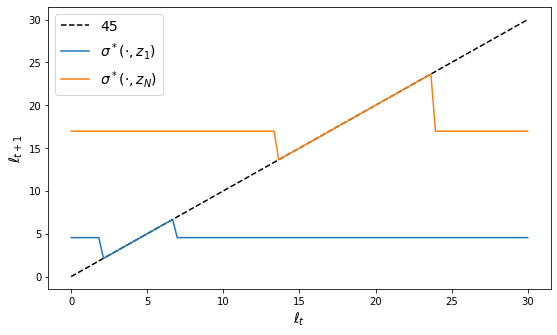

In [9]:
σ_star = opi(model)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(l_grid, l_grid, "k--", label="45")
ax.plot(l_grid, l_grid[σ_star[:, 1]], 
        label="$\sigma^*(\cdot, z_1)$")
ax.plot(l_grid, l_grid[σ_star[:, -1]], 
        label="$\sigma^*(\cdot, z_N)$")
ax.set_xlabel("$\ell_t$", fontsize=fontsize)
ax.set_ylabel("$\ell_{t+1}$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

Let's simulate dynamics.

In [10]:
def sim_dynamics(model, ts_length):

    β, κ, α, p, w, l_grid, z_grid, Q = (
       model.β, model.κ, model.α, model.p,
       model.w, model.l_grid, model.z_grid, model.Q)
    σ_star = opi(model)
    mc = qe.MarkovChain(Q, z_grid)
    z_sim_idx = mc.simulate_indices(ts_length)
    z_sim = z_grid[z_sim_idx]
    l_sim_idx = np.empty(ts_length, dtype=int)
    l_sim_idx[0] = 32

    for t in range(ts_length-1):
        l_sim_idx[t+1] = σ_star[l_sim_idx[t], z_sim_idx[t]]

    l_sim = l_grid[l_sim_idx]

    y_sim = np.empty_like(l_sim)
    for i, l in enumerate(l_sim):
        y_sim[i] = p * z_sim[i] * l_sim[i]**α

    return l_sim, y_sim, z_sim

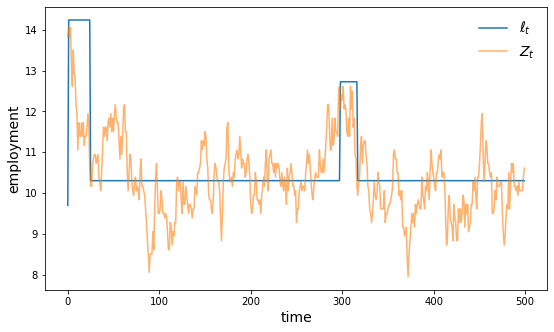

In [11]:
ts_length = 500
model = create_hiring_model()
β, κ, α, p, w, l_grid, z_grid, Q = (
   model.β, model.κ, model.α, model.p,
   model.w, model.l_grid, model.z_grid, model.Q)
l_sim, y_sim, z_sim = sim_dynamics(model, ts_length)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(range(ts_length), l_sim, label="$\ell_t$")
ax.plot(range(ts_length), z_sim, alpha=0.6, label="$Z_t$")
ax.legend(fontsize=fontsize, frameon=False)
ax.set_ylabel("employment", fontsize=fontsize)
ax.set_xlabel("time", fontsize=fontsize)
plt.show()